Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name below:

In [ ]:
NAME = ""

---

<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

# High-Resolution Movers
Keywords: keep_history(), MoveMap, SmallMover(), ShearMover(), angle_max(), set_bb(), MinMover(), MonteCarlo(), boltzmann(), TrialMover(), SequenceMover(), RepeatMover()

In [1]:
# Notebook setup
import sys
from pyrosetta import *
from pyrosetta.teaching import *
init()

PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python36.ubuntu 2020.23+release.0d6f90a8cb9fa0567ca76bb71ee93bfe73340c70 2020-06-04T19:12:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python36.ubuntu r257 2020.23+release.0d6f90a8cb9 0d6f90a8cb9fa0567ca76bb71ee93bfe73340c70 http://www.pyrosetta.org 2020-06-04T19:12:24
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.6/dist-packages/pyrosetta-2020.23+release.0d6f90a8cb9-py3.6-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1000202590 seed_offset=0 real_seed=1000202590
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1000202590 RG_type=mt19937


**Make sure you are in the directory with the pdb files:**

In the last workshop, you encountered the `ClassicFragmentMover`, which inserts a short sequence of backbone torsion angles, and the `SwitchResidueTypeSetMover`, which doesn’t actually change the conformation of the pose but instead swaps out the residue types used.


In this workshop, we will introduce a variety of other `Movers`, particularly those used in high-resolution refinement (e.g., in Bradley’s 2005 paper).

Before you start, load the cleaned cetuximab protein 1YY8 that we've worked with previously (but just one Fab fragment, chain A and B) and make a copy of the pose so we can compare later:

```
start = pose_from_pdb("1YY8.clean.pdb")
test = Pose()
test.assign(start)
```

In [2]:
# YOUR CODE HERE
start = pose_from_pdb("inputs/1YY8.clean.pdb")
test = Pose()
test.assign(start)

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 980 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.856094 seconds.
core.import_pose.import_pose: File 'inputs/1YY8.clean.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ARG 18
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue ARG 18
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NE  on residue ARG 18
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue ARG 18
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH1 on residue ARG 18
core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH2 on residue ARG 18
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLN:NtermProteinFull 214
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLN:N

core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /usr/local/lib/python3.6/dist-packages/pyrosetta-2020.23+release.0d6f90a8cb9-py3.6-linux-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/usr/local/lib/python3.6/dist-packages/pyrosetta-2020.23+release.0d6f90a8cb9-py3.6-linux-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.200796 seconds to load from binary
core.pack.pack_rotamers: built 85 rotamers at 4 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph


OPTIONAL: For convenient viewing in PyMOL, set the names of both poses:
```
start.pdb_info().name("start")
test.pdb_info().name("test")
pmm = PyMOLMover()
```

In [3]:
# YOUR CODE HERE
start.pdb_info().name("start")
test.pdb_info().name("test")
pmm = PyMOLMover("127.255.255.7",65000)

We also want to activate the `keep_history` setting so that PyMOL will keep separate frames for each conformation as we modify it (more on this shortly):
```
pmm.keep_history(True)
pmm.apply(start)
pmm.apply(test)
```

In [5]:
# YOUR CODE HERE
pmm.keep_history(True)
pmm.apply(start)
pmm.apply(test)

## Small and Shear Moves

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

Small mover (1YY9, residue 277):

In [ ]:
from pathlib import Path
gifPath = Path("./Media/small-mover.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png',width='400')

Shear mover (1YY9, residue 277):

In [ ]:
gifPath = Path("./Media/shear-mover.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png',width='400')

The simplest move types are small moves, which perturb φ or ψ of a random residue by a random small angle, and shear moves, which perturb φ of a random residue by a small angle and ψ of the same residue by the same small angle of opposite sign.

For convenience, the `SmallMover` and `ShearMover` can do multiple rounds of perturbation. They also check that the new φ/ψ combinations are within an allowable region of the Ramachandran plot by using a Metropolis acceptance criterion based on the rama score component change. (The `rama` score is a statistical score from Simons et al. 1999, parametrized by bins of φ/ψ space.) Because they use the Metropolis criterion, we must also supply $kT$.

Finally, like most `Movers`, these require a `MoveMap` object to specify which degrees of freedom are fixed and which are free to change. Thus, we can create our `Movers` like this:

```
kT = 1.0
n_moves = 1
movemap = MoveMap()
movemap.set_bb(True)
small_mover = SmallMover(movemap, kT, n_moves)
shear_mover = ShearMover(movemap, kT, n_moves)
```

In [5]:
# YOUR CODE HERE
kT = 1.0
n_moves = 1
movemap = MoveMap()
movemap.set_bb(True)
small_mover = SmallMover(movemap, kT, n_moves)
shear_mover = ShearMover(movemap, kT, n_moves)

We can also adjust the maximum magnitude of the perturbations and get the information back from the `SmallMover` by printing it:

```
small_mover.angle_max("H", 25)
small_mover.angle_max("E", 25)
small_mover.angle_max("L", 25)
print(SmallMover)
```

In [6]:
# YOUR CODE HERE

small_mover.angle_max("H", 25)
small_mover.angle_max("E", 25)
small_mover.angle_max("L", 25)
print(SmallMover)

<class 'pyrosetta.rosetta.protocols.simple_moves.SmallMover'>


Here, *"H"*, *"E"*, and *"L"* refer to helical, sheet, and loop residues — as they did in the fragment library file — and the magnitude is in degrees. We will set all the maximum angles to 25° to make the changes easy to visualize. (The default values in Rosetta are 0°, 5°, and 6°, respectively.)

### Test your mover by applying it to your pose
```
small_mover.apply(test)
```

In [7]:
# YOUR COD
small_mover.apply(test)
pmm.apply(test)
                  


core.scoring.ramachandran: shapovalov_lib::shap_rama_smooth_level of 4( aka highest_smooth ) got activated.
basic.io.database: Database file opened: scoring/score_functions/rama/shapovalov/kappa25/all.ramaProb


Confirm that the change has occurred by comparing the start and test poses in PyMOL.

```
pmm.apply(test)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Second, try the PyMOL animation controls on the bottom right corner of the Viewer window. There should be a play button (►) as well as frame-forward, rewind, etc. Play the movie to watch PyMOL shuffle your pose move back and forth.

__Question:__ Can you identify which torsion angles changed? By how much? If it is hard to view on the screen, it may help to use your programs from previous workshops to compare torsion angles or coordinates.

### Comparing small and shear movers

Reset the test pose by re-assigning it the conformation from `start`, and create and view a second test pose (`test2`) in the same manner. Reset the existing `MoveMap` object to only allow the backbone angles of residue 50 to move. (Hint: Set all residues to `False`, then set just residues 50 and 51 to `True`). Note that the `SmallMover` contains a pointer to your `MoveMap`, and so it will automatically know you have made these changes and use the modified `MoveMap` in future moves.

```
test2 = Pose()
test2.assign(start)
test2.pdb_info().name("test2")
pmm.apply(test2)

movemap.set_bb(False)
movemap.set_bb(50, True)
movemap.set_bb(51, True)
print(movemap)
```

In [8]:
# YOUR CODE HERE
test2 = Pose()
test2.assign(start)
test2.pdb_info().name("test2")
pmm.apply(test2)

movemap.set_bb(False)
movemap.set_bb(50, True)
movemap.set_bb(51, True)
print(movemap)

small_mover.apply(test)
shear_mover.apply(test2)
pmm.apply(test)
pmm.apply(test2)


-------------------------------
  resnum     Type  TRUE/FALSE 
-------------------------------
 DEFAULT      BB     FALSE
 DEFAULT      SC     FALSE
 DEFAULT      NU     FALSE
 DEFAULT  BRANCH     FALSE
     050      BB      TRUE
     051      BB      TRUE
-------------------------------
 jumpnum     Type  TRUE/FALSE 
-------------------------------
 DEFAULT     JUMP    FALSE
-------------------------------
  resnum  atomnum     Type  TRUE/FALSE 
-------------------------------
 DEFAULT               PHI    FALSE
 DEFAULT             THETA    FALSE
 DEFAULT                 D    FALSE
 DEFAULT               RB1    FALSE
 DEFAULT               RB2    FALSE
 DEFAULT               RB3    FALSE
 DEFAULT               RB4    FALSE
 DEFAULT               RB5    FALSE
 DEFAULT               RB6    FALSE
-------------------------------




Make one small move on one of your test poses and one shear move on the other test pose. Output both poses to PyMOL using the `PyMOLMover`. Be sure to set the name of each pose so they are distinguishable in PyMOL. Show only backbone atoms and view as lines or sticks. Identify the torsion angle changes that occurred.

```
small_mover.apply(test)
shear_mover.apply(test2)
pmm.apply(test)
pmm.apply(test2)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

__Question:__ What was the magnitude of the change in the sheared pose? How does the displacement of residue 60 compare between the small- and shear-perturbed poses?

## Minimization Moves

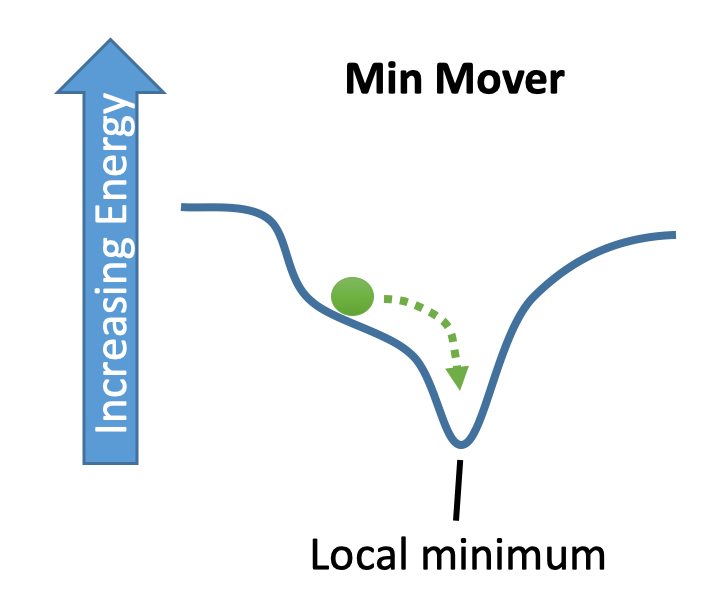

In [10]:
from IPython.display import Image
Image('./Media/minmover.png',width='300')

The `MinMover` carries out a gradient-based minimization to find the nearest local minimum in the energy function, such as that used in one step of the Monte-Carlo-plus-Minimization algorithm of Li & Scheraga.

```
min_mover = MinMover()
```

In [9]:
# YOU
min_mover = MinMover()
mm4060 = MoveMap()
mm4060.set_bb_true_range(40, 60)
scorefxn = get_fa_scorefxn() #get the full-atom score function
min_mover.movemap(mm4060)
min_mover.score_function(scorefxn)
print(min_mover)

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
Mover name: MinMover, Mover type: MinMover, Mover current tag:NoTag
Minimization type:	linmin
Scorefunction:		ref2015
Score tolerance:	0.01
Nb list:		True
Deriv check:		False
Movemap:

-------------------------------
  resnum     Type  TRUE/FALSE 
-------------------------------
 DEFAULT      BB     FALSE
 DEFAULT      SC     FALSE
 DEFAULT      NU     FALSE
 DEFAULT  BRANCH     FALSE
     040      BB      TRUE
     041      BB      TRUE
     042      BB      TRUE
     043      BB      TRUE
     044      BB      TRUE
     045      BB      TRUE
     046      BB      TRUE
     047      BB      TRUE
     048      BB      TRUE
     049      BB      TRUE
     050      BB      TRUE
     051      BB      TRUE
     052      BB      TRUE
     053      BB      TRUE
     054      BB      TRUE
     055      BB      TRUE
     056      BB      TRUE
     057      BB      TRUE
     058      BB      TRUE
     059      BB      TRUE
     060      

3. The minimization mover needs at least a `MoveMap` and a `ScoreFunction`. You can also specify different minimization algorithms and a tolerance. (See Appendix A). For now, set up a new `MoveMap` that is flexible from residues 40 to 60, inclusive, using:

```
mm4060 = MoveMap()
mm4060.set_bb_true_range(40, 60)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Create a standard, full-atom `ScoreFunction`, attach these objects to the default `MinMover`, and print out the information in the `MinMover` with the following methods and check that everything looks right:

```
scorefxn = #get the full-atom score function
min_mover.movemap(mm4060)
min_mover.score_function(scorefxn)
print(min_mover)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Finally, attach an “observer”. The observer is configured to execute a `PyMOLMover.apply()` every time a change is observed in the pose coordinates. The `True` is a flag to ensure that PyMOL keeps a history of the moves.

```
observer = pyrosetta.rosetta.protocols.moves.AddPyMOLObserver(test2, True)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

4. Apply the `MinMover` to your sheared pose. Observe the output in PyMOL. (This may take a couple minutes — the Observer can slow down the minimization significantly).

```
min_mover.apply(test2)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

__Question:__ How much motion do you see, relative to the original shear move? How many coordinate updates does the *MinMover* try? How does the magnitude of the motion change as the minimization continues? At the end, how far has the Cα atom of residue 60 moved?

In [10]:
min_mover.apply(test2)
pmm.apply(test2)

## Monte Carlo Object


PyRosetta has several object classes for convenience for building more complex algorithms. One example is the `MonteCarlo` object. This object performs all the bookkeeping you need for creating a Monte Carlo search. That is, it can decide whether to accept or reject a trial conformation, and it keeps track of the lowest-energy conformation and other statistics about the search. Having the Monte Carlo operations packaged together is convenient, especially if we want multiple Monte Carlo loops to nest within each other or to operate on different parts of the protein.

To create the object, you need an initial test pose, a score function, and a temperature factor:

```
mc = MonteCarlo(test, scorefxn, kT)
```

In [11]:
# YOUR CODE HERE
mc = MonteCarlo(test, scorefxn, kT)

After the pose is modified by a mover, we tell the `MonteCarlo` object to automatically accept or reject the new conformation and update a set of internal counters by calling:

```
mc.boltzmann(test)
```

In [12]:
# YOUR CODE HERE
mc.boltzmann(test)
# NotImplementedError()

True

In [14]:
mc.show_scores()

protocols.moves.MonteCarlo: MonteCarlo:: last_accepted_score,lowest_score: 11866.6 11866.6


In [15]:
mc.show_counters()

protocols.moves.TrialCounter:              unk trials=      1;  accepts= 1.0000;  energy_drop/trial=   0.00000


In [16]:
mc.show_state()

protocols.moves.MonteCarlo: MC: 1  11866.6  11866.6  11866.6  11866.6  0  0  0  accepted thermally
protocols.moves.TrialCounter:              unk trials=      1;  accepts= 1.0000;  energy_drop/trial=   0.00000


5. Test out a `MonteCarlo` object. Before doing so, you may need to adjust your small and shear moves to smaller maximum angles (3–5°) so they are more likely to be accepted. Apply several small or shear moves on your `test` pose, output the score using `print(scorefxn(test))`, then call the `mc.boltzmann(test)` method of the `MonteCarlo` object. A response of `True` indicates the move is accepted, and `False` indicates that the move is rejected. If the move is rejected, the pose is automatically reverted for you to its last accepted state. Manually iterate a few times between moves and calls to `mc.boltzmann()`. Call `pmm.apply(test)` every time you get a `True` back from the `mc.boltzmann(test)` method. Do enough cycles to observe at least two `True` and two `False` outputs. Do the acceptances match what you expect given the scores you obtain? After doing a few cycles, use `mc.show_scores()` to find the score of the last accepted state and the lowest energy state. What energies do you find? Is the last accepted energy equal to the lowest energy?

```
# adjust the SmallMover
small_mover.angle_max("H", 3)
small_mover.angle_max("E", 5)
small_mover.angle_max("L", 6)
# and the ShearMover
shear_mover.angle_max("H", 3)
shear_mover.angle_max("E", 5)
shear_mover.angle_max("L", 6)
```

Then write your MonteCarlo loop below:

In [ ]:
# adjust the SmallMover
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# and the ShearMover
# YOUR CODE HERE
raise NotImplementedError()

6. See what information is stored in the Monte Carlo object using:
```
mc.show_scores()
mc.show_counters()
mc.show_state()
```

__Question:__ What information do you get from each of these?

## Trial Mover

In [ ]:
Image('./Media/trialmover.png',width='250')

A `TrialMover` combines a specified `Mover` with a `MonteCarlo` object. Each time a `TrialMover` is called, it performs a trial move and tests that move’s acceptance with the `MonteCarlo` object. You can create a `TrialMover` from any other type of `Mover`. You might imagine that, as we start nesting these together, we can build some complex algorithms!

```
trial_mover = TrialMover(small_mover, mc)
trial_mover.apply(test)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

7. Apply the `TrialMover` above ten times. Using `trial_mover.num_accepts()` and `trial_mover.acceptance_rate()`, what do you find?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

8. The `TrialMover` also communicates information to the `MonteCarlo` object about the type of moves being tried. Create a second `TrialMover` (`trial_mover2`) using a `ShearMover` and the same `MonteCarlo` object, and apply this second `TrialMover` ten times like above. After, look at the `MonteCarlo` object state (`mc.show_state()`).

__Question:__ Using information from `mc.show_state()`, what are the acceptance rates of each mover (`SmallMover` and `ShearMover`)? Which mover is accepted most often, and which has the largest energy drop per trial? What are the average energy drops?

## Sequence and Repeat Movers


A `SequenceMover` is another combination `Mover` and applies several `Movers` in succession. It is useful for building up complex routines and is constructed (and confirmed with a print statement) as follows:

```
seq_mover = SequenceMover()
seq_mover.add_mover(small_mover)
seq_mover.add_mover(shear_mover)
seq_mover.add_mover(min_mover)
print(seq_mover)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

The above example mover will apply first the small, then the shear, and finally the minimization movers.

9. Create and print a `TrialMover` using the `SequenceMover` above, and apply it five times to the test pose. How is the sequence mover shown by `mc.show_state()`?

A `RepeatMover` will apply its input Mover `n_repeats` times each time it is applied:

```
n_repeats = 3
repeat_mover = RepeatMover(trial_mover, n_repeats)
print(repeat_mover)
```

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

10. Use these tools to build up your own *ab initio* protocol. Create `TrialMovers` for 9-mer and 3-mer fragment insertions. First, create `RepeatMovers` for each and then create the `TrialMovers` using the same `MonteCarlo` object for each. Create a `SequenceMover` to do the 9-mer trials and then the 3-mer trials, and iterate the sequence 10 times.

__Problem:__ Use a pen and paper to write out a flowchartalgorithm:

11. *Hierarchical search*. Construct a `TrialMover` that tries to insert a 9-mer fragment and then refines the protein with 100 alternating small and shear trials before the next 9-mer fragment trial. The interesting part is this: you will use one `MonteCarlo` object for the small and shear trials, inside the whole 9-mer combination mover. But use a separate `MonteCarlo` object for the 9-mer trials. In this way, if a 9-mer fragment insertion is evaluated after the optimization by small and shear moves and is rejected, the pose goes all the way back to before the 9-mer fragment insertion.